# Image Classification Model for Doom and Animal Crossing Memes

This notebook aims to classify Doom and Animal Crossing Memes **from images alone**, by finetuning a pretrained CNN model (InceptionV3). This is also known as transfer learning.

TensorFlow 2.4.1 will be the framework of choice.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
print("TensorFlow", tf.__version__)

import os
import glob
import shutil
import random

TensorFlow 2.4.1


In [2]:
# check number of doom and animal crossing memes
print("Animal Crossing:", len(os.listdir("../input/doom-crossing/animal_crossing")))
print("Doom:", len(os.listdir("../input/doom-crossing/doom")))

Animal Crossing: 757
Doom: 840


## View images
Let's view some of the images provided.

../input/doom-crossing/animal_crossing



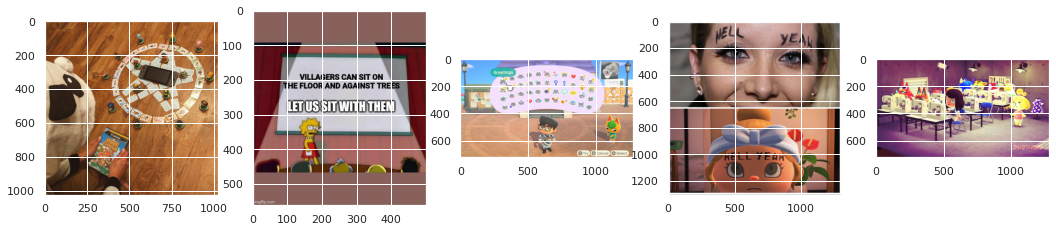

In [3]:
# note: images are provided in both jpg and png formats. I will simply load the first 5 images regardless of type.
def plotSampleImages(dirname):
    print(dirname)
    print()
    files = glob.glob(dirname + "/*")
    f, ax = plt.subplots(1, 5, figsize=(18,9))
    for i, file in enumerate(files[:5]):
        img = plt.imread(file)
        ax[i].imshow(img)
        #ax[i].axis('off')
    plt.show()

plotSampleImages("../input/doom-crossing/animal_crossing")

../input/doom-crossing/doom



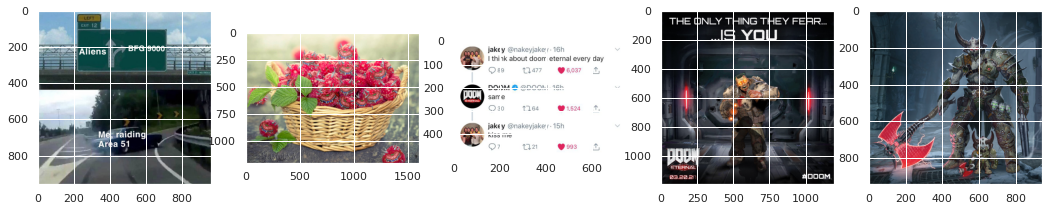

In [4]:
plotSampleImages("../input/doom-crossing/doom")

#### Observations:
* The given dataset contains more Doom images than Animal Crossing images. Given the small number of images, feeding the CNN model with more Doom images may cause the model to bias predictions towards Doom.
* The given images come in different dimensions.

## Data Preprocessing and Augmentation

1. Separate image files randomly into train and test directories. **Note that for the purposes of this notebook, the test set is in fact the validation set.** 
2. Create DataImageGenerator object and use the `flow_from_directory` method to perform data augmentation
3. Display augmented training images

### 1. Train test split

There are AT LEAST two methods to split the files into train and test (validation).

a) **Use the `image_dataset_from_directory` method from `tf.keras.preprocessing`**, which will directly give us train and test datasets in the tf.data.Dataset form. This will yield batches of images together with their labels. Details [here](https://keras.io/api/preprocessing/image/#imagedatasetfromdirectory-function) with an [example](https://keras.io/examples/vision/image_classification_from_scratch/). Any image augmentations can then either be built into the neural network model itself, or mapped to the resulting tf.data.Dataset.

b) **Perform a random split on the filenames and copy them into a new directory using shutil.** The new directory will contain train and test subdirectories, where the pictures will be stored in folders according to their labels. Finally, ImageDataGenerator objects are created and their `flow_from_directory` method is used to generate batches of augmented data. 

For this case, we will be going with method (b) which, although a slower method, is not shown in the docs. After performing the operation, the structure of the copied dataset will be as follows:
```
working
|__ train:
    |______ doom: [aaa.jpg, bbb.1.jpg ...]
    |______ animal_crossing: [ccc.0.jpg, ddd.1.jpg ...]
|__ test:
    |______ doom: [eee.2000.jpg, fff.2001.jpg ...]
    |______ animal_crossing: [ggg.2000.jpg, hhh.2001.jpg ...]
```


Note that this method is still possible with the small number of images. For a larger image dataset, it may be prudent to use the first method instead.

In [5]:
PATH = "../working"
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

# constants for preprocessing
IMG_HT = 256
IMG_WT = 256
BATCH_SIZE = 32

#### Method 1 (for reference)

In [6]:
root_dir = "../input/doom-crossing"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HT, IMG_WT),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HT, IMG_WT),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

Found 1597 files belonging to 2 classes.
Using 1278 files for training.
Found 1597 files belonging to 2 classes.
Using 319 files for validation.


#### Method 2

In [7]:
%%time

PATH = "../working"
root_dir = '../input/doom-crossing/'
labels = ['animal_crossing', 'doom']
test_ratio = 0.20

# create directories for train and test
for label in labels:
    os.makedirs(PATH + "/train/" + label)
    os.makedirs(PATH + "/test/" + label)
    src = root_dir + label
    
    # shuffle and split all images of each label
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                [int(len(allFileNames) * (1 - test_ratio))])

    # create lists of filenames of train images and test images
    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]
    
    print("Label:", label)
    print("Total images:", len(allFileNames))
    print("Training:", len(train_FileNames))
    print("Testing:", len(test_FileNames))
    print()
    
    # copy each image file to the new directory
    for name in train_FileNames:
        shutil.copy(name, train_dir + "/" + label)

    for name in test_FileNames:
        shutil.copy(name, test_dir + "/" + label)
        
print("Copying complete")

Label: animal_crossing
Total images: 757
Training: 605
Testing: 152

Label: doom
Total images: 840
Training: 672
Testing: 168

Copying complete
CPU times: user 848 ms, sys: 2.72 s, total: 3.57 s
Wall time: 24.4 s


### 2. DataImageGenerator Object and Data Augmentation

Due to the small number of training images, there is a large risk of overfitting. One way to mitigate this problem is to artificially create more training data by applying random transformations to existing training images. Note that the augmentations should be applied to the training ImageDataGenerator and not test ImageDataGenerator.

In [8]:
# train ImageDataGenerator with applied augmentations to artificially increase training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True)

# test ImageDataGenerator (only rescaled, no augmentations)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
# train flow from directory
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size=BATCH_SIZE,
                                                   target_size=(IMG_HT, IMG_WT),
                                                   class_mode='binary')

# test flow from directory
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=BATCH_SIZE,
                                                 target_size=(IMG_HT, IMG_WT),
                                                 class_mode='binary',
                                                 shuffle=False)

Found 1277 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


### 3. Display augmented training images

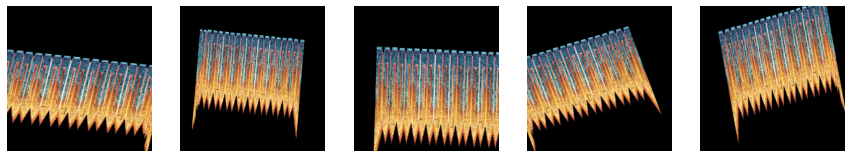

In [10]:
# function to plot images
def plotAugmentedImages(images_arr):
    f, axs = plt.subplots(1, len(images_arr), figsize=(3 * len(images_arr), 5))
    for img, ax in zip(images_arr, axs):
        ax.imshow(img)
        ax.axis('off')
        
# view a sample training image with 5 augmentations
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotAugmentedImages(augmented_images)

## Creating the image classification model

Despite image augmentation, it is still difficult to train an accurate model with only the given images. Hence, we will bring in a model (InceptionV3) with weights pretrained on ImageNet, lock the hidden layers, and train only the output layer on our training images. This is also called transfer learning. An example can be found [here](https://www.tensorflow.org/tutorials/images/transfer_learning#use_data_augmentation).

### 1. Import pretrained model and weights

In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

model_pretrained = InceptionV3(input_shape=(IMG_HT, IMG_WT, 3),
                               include_top=False,      # to exclude classification layers at the top
                               weights='imagenet')     # pre-trained weights

# freeze hidden layers
for layer in model_pretrained.layers:
    layer.trainable = False

model_pretrained.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________

### 2. Define the convolutional base
We may choose any Concatenate layer in the ResNet50 model as our last layer for the convolutional base.

In [12]:
last_layer = model_pretrained.get_layer('mixed4')
last_layer_output = last_layer.output
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 14, 14, 768)


### 3. Complete the finetuned model

We will stack a dense layer and a dropout layer on top of the convolutional base. Our final layer will consist of a single neuron as we are performing a binary prediction.

In [13]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

x = layers.Flatten()(last_layer_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(model_pretrained.input, x)
model.compile(optimizer=Adam(lr=0.00005),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

### 4. Train the model

In [14]:
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=100,
                    verbose=2)

Epoch 1/100
40/40 - 176s - loss: 1.0873 - acc: 0.5881 - val_loss: 0.4973 - val_acc: 0.7812
Epoch 2/100
40/40 - 168s - loss: 0.4942 - acc: 0.7612 - val_loss: 0.4075 - val_acc: 0.8313
Epoch 3/100
40/40 - 169s - loss: 0.4295 - acc: 0.8034 - val_loss: 0.3431 - val_acc: 0.8625
Epoch 4/100
40/40 - 167s - loss: 0.3772 - acc: 0.8348 - val_loss: 0.3195 - val_acc: 0.8594
Epoch 5/100
40/40 - 166s - loss: 0.3660 - acc: 0.8434 - val_loss: 0.3190 - val_acc: 0.8625
Epoch 6/100
40/40 - 166s - loss: 0.3442 - acc: 0.8496 - val_loss: 0.3236 - val_acc: 0.8531
Epoch 7/100
40/40 - 166s - loss: 0.3363 - acc: 0.8567 - val_loss: 0.3304 - val_acc: 0.8625
Epoch 8/100
40/40 - 165s - loss: 0.3397 - acc: 0.8551 - val_loss: 0.3054 - val_acc: 0.8750
Epoch 9/100
40/40 - 165s - loss: 0.3461 - acc: 0.8473 - val_loss: 0.3023 - val_acc: 0.8687
Epoch 10/100
40/40 - 165s - loss: 0.3194 - acc: 0.8528 - val_loss: 0.3018 - val_acc: 0.8719
Epoch 11/100
40/40 - 165s - loss: 0.2959 - acc: 0.8747 - val_loss: 0.3155 - val_acc: 0.86

### 5. Plot accuracy graph

We can plot a graph of accuracy against training epochs to observe the gain in accuracy. If a larger number of epochs are used, it is likely that training accuracy will start to plateau after a certain number of epochs. At this point, the test accuracy may even start to decrease as the model would have overfitted to the training set.

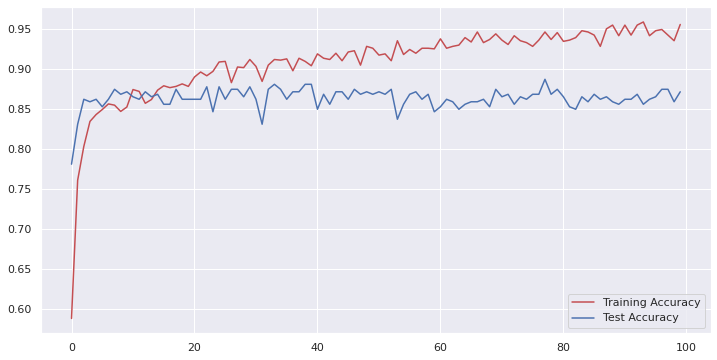

In [15]:
acc = history.history['acc']
test_acc = history.history['val_acc']
epochs = range(len(acc))

f = plt.subplots(figsize=(12,6))
plt.plot(epochs, acc, 'r-', label="Training Accuracy")
plt.plot(epochs, test_acc, 'b', label="Test Accuracy")
plt.legend(loc='lower right')

### 6. Trends observed
All model training runs were conducted over 100 epochs.

I have attempted several modifications to the model and have noted the following observations:
* On my first attempt, as the number of epochs increased, training accuracy increased while validation accuracy remained relatively stagnant. Hence the deviation between training and validation accuracy increased, indicating that the model has overfit to the training data. (mixed6, lr==0.00005)
* Decreasing the number of layers in the convolutional base of the model narrowed the difference between training and validation accuracy, indicating that the model is generalising better. (mixed4, lr==0.00005) That being said, reducing the convolutional base (mixed3, lr==0.00005) or the learning rate (mixed4, lr==0.00001) by too much will result in lower accuracies overall.
* Validation accuracy seems to stagnate after around 30-40 epochs, hence training the model with this number of epochs would be enough.

## Model predictions

Note the labels; '0' represents an Animal Crossing meme while '1' represents a Doom meme.

In [16]:
# confirm correct label names
test_generator.class_indices

{'animal_crossing': 0, 'doom': 1}

Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Predictions:
 [0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0]


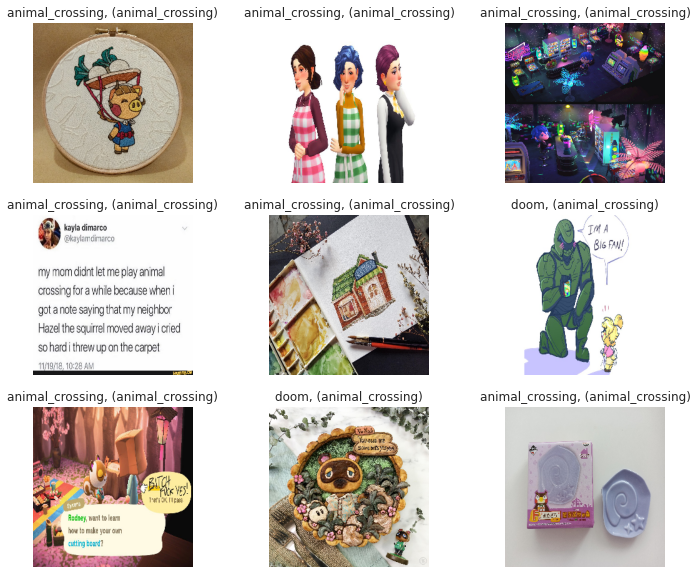

In [17]:
# retrieve a batch of imagesconfusion_matrixtion set and predict their labels
# X: images of batch, y: labels of batch, y_pred: predictions of batch
X, y = test_generator.next()
y_pred = model.predict_on_batch(X).flatten()

# convert batch predictions and labels to int
y_pred = np.round(y_pred).astype(int)
y = np.round(y).astype(int)

# print labels and respective predictions of each image in the batch
print('Labels:\n', y)
print('Predictions:\n', y_pred)

# show first 9 images of the batch.
# title format: prediction, (actual label)
plt.figure(figsize=(12, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X[i])
    plt.title(labels[y_pred[i]] + ", (" + labels[y[i]] + ")")
    plt.axis("off")

## Further exploration

The following exploration questions are taken from [this task](https://github.com/gau-nernst/mlda-acad-recruitment).

### 1. Which are the misclassified photos? How do you explain why they are misclassified? How can you help your model classify those photos correctly?

One reason why some photos may be misclassified is due to the **small training set** with less than 1000 images in each category. Furthermore, the training set is **imbalanced** - there are more Doom memes than Animal Crossing memes. To fix this, we could add more memes to the training set and ensure that the number of images in each class becomes equal.

Another possible reason for misclassification is that the model's convolutional base had **difficulty capturing certain features as it was not explicitly trained on them (eg. entire sentences)**. To help the model classify such photos correctly, the training set can be expanded with more photos that are similar to the currently misclassified photos.

A third reason is that some images simply **do not have any visual features that resemble content from either Animal Crossing or Doom.** The message behind those images are highly implicit and would require a person with prior knowledge of either game to be able to infer the meaning of the meme. This is the hardest problem to combat. To mitigate this problem, extra information would be needed (eg. image metadata, profile of the original poster) in order to form a better prediction.

By plotting a confusion matrix, we can easily see that **the proportion of Animal Crossing memes wrongly classified as Doom memes far exceeds the proportion of Doom memes wrongly classified as Animal Crossing memes.**

In [18]:
step_per_epoch = test_generator.n // BATCH_SIZE
labels = []
predictions = []

# get labels and predictions for each batch in test_generator until end
for step in range(step_per_epoch):
    X, y = test_generator.next()
    y_pred = model.predict(X)
    labels.extend(y)
    predictions.extend(y_pred.flatten())

# round predictions to nearest integer value
predictions = np.round(predictions).astype(int)

# show respective labels and predictions
print("First 5 labels:", labels[:5])
print("First 5 predictions:", predictions[:5])

First 5 labels: [0.0, 0.0, 0.0, 0.0, 0.0]
First 5 predictions: [0 0 0 0 1]


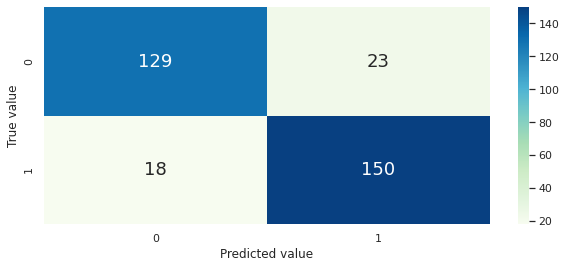

Accuracy: 0.872
False positive rate (wrongly classified Animal Crossing memes): 0.151
False negative rate (wrongly classified Doom memes): 0.107


In [19]:
# available functions: sklearn.metrics.confusion_matrix or tf.math.confusion_matrix
from sklearn.metrics import confusion_matrix

# plot confusion matrix
conf_matrix = confusion_matrix(labels, predictions)
f = plt.subplots(figsize=(10,4))
sns.heatmap(conf_matrix, cmap="GnBu", annot=True, annot_kws={'size': 18}, fmt='g');
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.show()

# calculate false positive rate and false negative rate
tn = conf_matrix[0][0]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
tp = conf_matrix[1][1]
print("Accuracy: {:.3f}".format((tp+tn)/test_generator.n))
print("False positive rate (wrongly classified Animal Crossing memes): {:.3f}".format(fp/(fp+tn)))
print("False negative rate (wrongly classified Doom memes): {:.3f}".format(fn/(fn+tp)))

### 2. How do you know if your model has actually learned to classify the images? Or is it simply very lucky at guessing?

Both training and validation accuracies increase with each epoch, and are well above 50% for each epoch on average, which is the baseline for a binary classification task (random guessing will be 50% correct). We can also plot the results of any of the convolutional layers to observe the patterns that the model has learnt.

### 3. What happens if you ask your model to classify a new image which is neither a Doom nor an Animal Crossing meme? You can try to upload a random photo and generate prediction on it to see the results. How would you modify your model to handle this situation?

The model will output a **prediction with a numeric value that is close to 0.5**. A predicted value of exactly 0.5 would mean that the predicted class is indeterminate - it is equally likely to be a Doom or Animal Crossing meme. To handle such a situation, **a bound can be imposed when converting the numeric prediction into the predicted label**, such that we will only consider the image as a Doom or Animal Crossing meme if the predicted value is at least a certain value higher or lower than 0.5. 

For example, we could only consider predicted value < 0.4 as a predicted Animal Crossing meme, and a predicted value > 0.6 a predicted Doom meme.

### 4. After having successfully trained a model to classify Doom and Animal Crossing memes, you want your model to classify other memes as well, such as those from Genshin Impact. How would you avoid retraining the model from scratch?

Freeze all layers except the last (output) layer. **Output layer should be a Dense layer with 3 neurons and softmax activation** - each neuron will output the probability of the image belonging to each of the 3 classes. If further fine-tuning is required, the Dense layers that precede the output layer may be unfreezed and tuned. Dense and Dropout layers may be added/removed from the model.

In any case, the convolutional base should never be retrained as this would destroy what the pretrained model (InceptionV3) has learnt from the ImageNet dataset, which is crucial for identifying features in our own training/test images.

## Future work

* Visualising output of hidden layers
* Tuning Dense and Dropout layers